# EasyMLP: Some Simple Examples

## Imports

In [1]:
import sys
sys.path.append(".")
from easy_mlp.models import MLP
from easy_mlp.trainers import MLPTrainer
from easy_mlp.data import get_tensors, get_data_loaders
from easy_mlp.helpers import get_loss_fn, get_optimiser, param_init

import torch
import numpy as np
import pretty_plotly.plot as pp
from sklearn.datasets import load_iris, make_classification, make_regression
from sklearn.model_selection import train_test_split

## Set Device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

## Regression

### Data Loading and Preprocessing

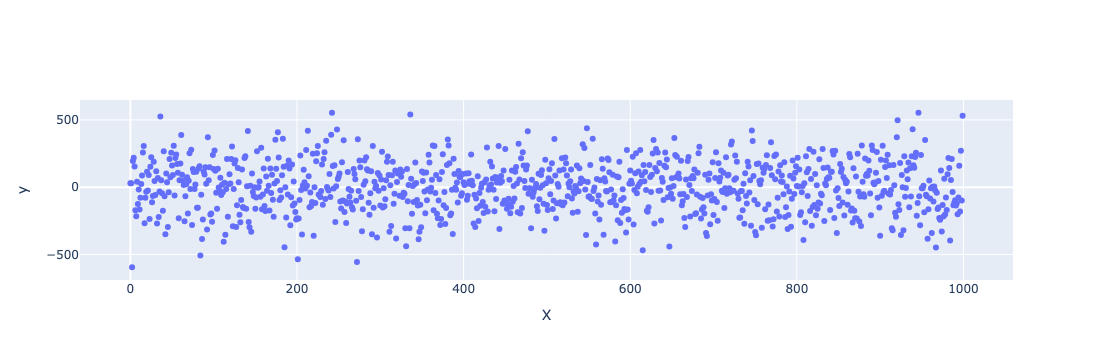

In [3]:
# Generate random data
X, y = make_regression(n_samples=1000, n_features=100)
x = np.arange(0, y.shape[0])
pp.plot_data(x, y, x_label="X", y_label="y")

In [4]:
# Dataloading parameters
batch_size = 8
test_size = 0.2
val_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (640, 100)
y_train: (640,)
X_val: (160, 100)
y_val: (160,)
X_test: (200, 100)
y_test: (200,)


In [5]:
# Get tensors and dataloaders
X_train, y_train, X_val, y_val = get_tensors(X_train, y_train, X_val, y_val)
train_loader, val_loader = get_data_loaders(X_train, y_train, X_val, y_val, batch_size)

### Building the Model

In [6]:
# Training parameters
num_train_epochs = 20
l_rate = 1e-03
loss_choice = "mse"
optim_choice = "sgd"

# Create configuration for model layers
layer_config_1 = [ # a simple linear regression model (a perceptron with no activation)
    (X_train.shape[1], None, None),
    (1, None, None),
]

layer_config_2 = [ # a multi-layer perceptron
    (X_train.shape[1], None, None),
    (200, "relu", None),
    (300, "relu", None),
    (400, "relu", 0.1),
    (200, "relu", None),
    (1, None, None),
]

# Initialise model
reg_model = MLP(layer_config=layer_config_2, model_name="LinRegModel")
reg_model.set_model_layers()

# Initialise model parameters
reg_model.apply(lambda m: param_init(m, "xavier"))

# Move model to selected device
reg_model.to(device)

print(reg_model)
print(f"Number of trainable parameters: {sum(p.numel() for p in reg_model.parameters())}")

MLP(
  (model): ModuleList(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=400, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=400, out_features=200, bias=True)
    (8): ReLU()
    (9): Linear(in_features=200, out_features=1, bias=True)
  )
)
Number of trainable parameters: 281301


### Training the Model

#### Loss Function and Optimiser

In [7]:
loss_fn = get_loss_fn("mse")  # Mean-square error loss because this a regression task
optimiser = get_optimiser("adam", reg_model, l_rate)

#### Training Loop

In [8]:
reg_trainer = MLPTrainer(type="reg", is_multiclass=False)

reg_trainer.train(
    reg_model,
    num_train_epochs,
    optimiser,
    loss_fn,
    train_loader,
    val_loader,
    device=device,
)

    |                       TRAINING SET                       ||                      VALIDATION SET                      |
    |   Loss   ||   RMSE   ||   MSE    ||   MAE    ||    R2    ||   Loss   ||   RMSE   ||   MSE    ||   MAE    ||    R2    |
001 | 2.07e+05 || 1.61e+02 || 2.59e+04 || 1.25e+02 || 2.39e-01 || 5.27e+03 || 7.26e+01 || 5.27e+03 || 5.79e+01 || 8.50e-01 |
002 | 2.93e+04 || 6.05e+01 || 3.66e+03 || 4.75e+01 || 8.92e-01 || 1.85e+03 || 4.30e+01 || 1.85e+03 || 3.40e+01 || 9.48e-01 |
003 | 9.20e+03 || 3.39e+01 || 1.15e+03 || 2.67e+01 || 9.66e-01 || 1.30e+03 || 3.61e+01 || 1.30e+03 || 2.75e+01 || 9.63e-01 |
004 | 4.88e+03 || 2.47e+01 || 6.10e+02 || 1.99e+01 || 9.82e-01 || 1.37e+03 || 3.71e+01 || 1.37e+03 || 2.95e+01 || 9.61e-01 |
005 | 2.97e+03 || 1.93e+01 || 3.71e+02 || 1.49e+01 || 9.89e-01 || 1.10e+03 || 3.32e+01 || 1.10e+03 || 2.60e+01 || 9.69e-01 |
006 | 2.57e+03 || 1.79e+01 || 3.21e+02 || 1.39e+01 || 9.91e-01 || 1.23e+03 || 3.51e+01 || 1.23e+03 || 2.81e+01 || 9.65e-01 |


#### Visualising Training Results

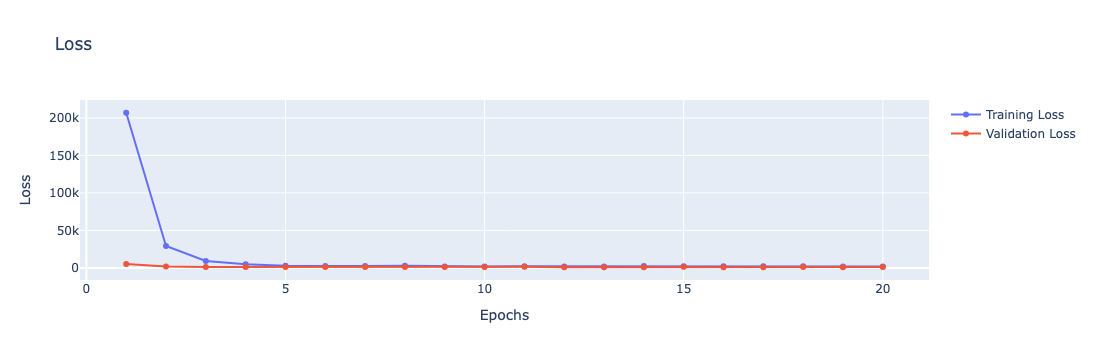

In [9]:
reg_trainer.mm.get_metric_chart("loss")

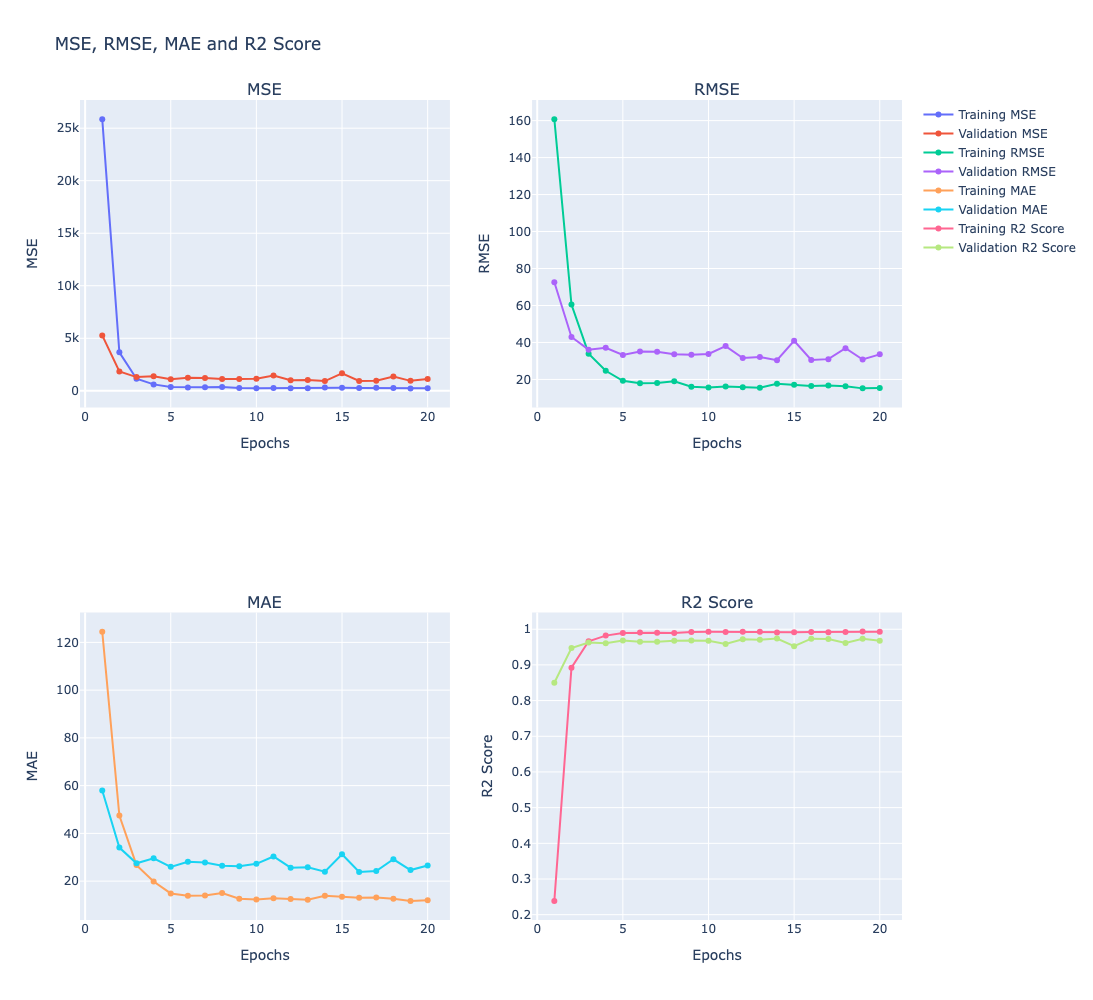

In [10]:
reg_trainer.mm.get_metric_chart_collection(["mse", "rmse", "mae", "r2"])

### Evaluating the Model on Test Data

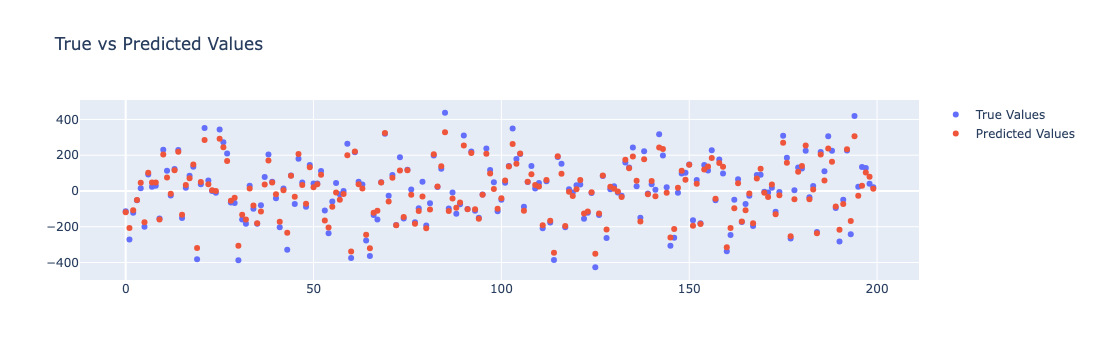

In [11]:
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

reg_model.eval()

with torch.no_grad():
    test_preds = reg_model(X_test)
    test_preds = test_preds.float().cpu().numpy().flatten()

x = np.arange(0, X_test.shape[0])
pp.plot_data(
    true_vals=pp.create_trace(x, y_test, name="True Values", mode="markers"),
    pred_vals=pp.create_trace(x, test_preds, name="Predicted Values", mode="markers"),
    title="True vs Predicted Values",
)

## Binary Classification

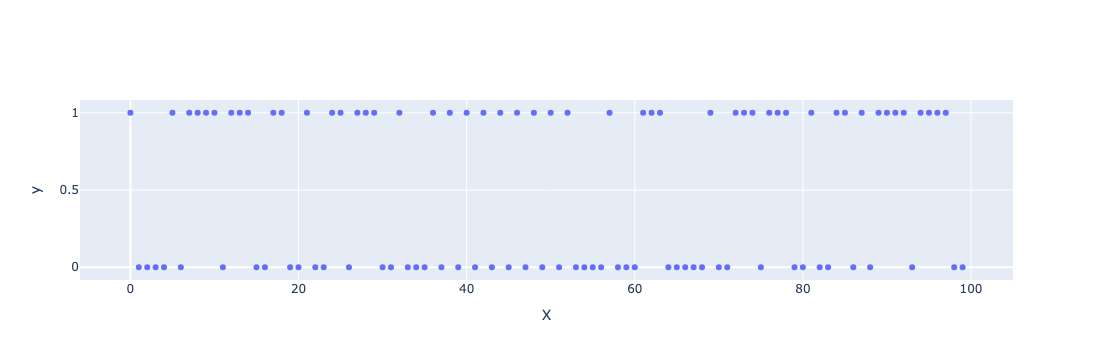

In [12]:
X, y = make_classification(n_classes=2)
x = np.arange(0, y.shape[0])
pp.plot_data(x, y, x_label="X", y_label="y")